In [15]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch_geometric.datasets import UPFD

In [16]:
df = pd.read_csv("./datasets/politifact.csv")

df.head()

,Unnamed: 0,sources,sources_dates,sources_post_location,sources_quote,curator_name,curated_date,fact,sources_url,curators_article_title,curator_complete_article,curator_tags
0,0,Viral image,2021-03-20 00:00:00,a Facebook post:\n,\nSays Disneyland is enforcing a “no scream” p...,Ciara O'Rourke,2021-03-22 00:00:00,false,https://www.politifact.com/factchecks/2021/mar...,"\nNo, Disneyland isn’t enforcing a ‘no scream’...",\nBack in July a Japanese amusement park drew ...,"Facebook Fact-checks,Coronavirus,Viral image"
1,1,Viral image,2021-01-24 00:00:00,a Facebook post:\n,\nVideo “proves 100% that President Joe Biden ...,Ciara O'Rourke,2021-03-22 00:00:00,pants-fire,https://www.politifact.com/factchecks/2021/mar...,"\nNo, this video doesn’t prove Biden isn’t hum...",\nA recent Facebook post uses a video clip of ...,"Facebook Fact-checks,Viral image"
2,2,Terry McAuliffe,2021-03-10 00:00:00,a speech:\n,\n“If you look at the average teacher pay comp...,Warren Fiske,2021-03-22 00:00:00,true,https://www.politifact.com/factchecks/2021/mar...,\nVa. teachers pay ranks last in U.S. compared...,"\n""If you look at the average teacher pay comp...","Education,Income,Wealth,Virginia,Terry McAuliffe"
3,3,TikTok posts,2021-03-17 00:00:00,a video caption:\n,\n“You will need a WHO Yellow Vaccination Pass...,Daniel Funke,2021-03-22 00:00:00,barely-true,https://www.politifact.com/factchecks/2021/mar...,"\nNo, you don’t need a WHO vaccination certifi...",\nA popular TikTok video said that if you want...,"Facebook Fact-checks,Coronavirus,TikTok posts"
4,4,Mike Bost,2021-03-15 00:00:00,a radio,\nThe American Rescue Plan Act “does not” incl...,Kiannah Sepeda-Miller,2021-03-21 00:00:00,half-true,https://www.politifact.com/factchecks/2021/mar...,\nDoes the American Rescue Plan limit how stat...,\nAfter failing to stop the $1.9 trillion COVI...,"Federal Budget,State Budget,Illinois,Coronavir..."


In [39]:
df.sources_quote[2], df.fact[2]

('\n“If you look at the average teacher pay compared to the average pay of your citizens, Virginia ranks last.”\n',
 'true')

In [33]:
df.sources_quote[1000], df.fact[1000], df.sources_post_location[1000]

('\nThe coronavirus pandemic is “effectively over” in the United Kingdom and “there is absolutely no need for vaccines.”\n',
 'false',
 ' a blog post:\n')

In [29]:
df.sources_quote.apply(lambda x: len(x)).sort_values(ascending=False)

4606     450
726      439
11929    402
17440    395
5720     393
        ... 
15696     14
18722     13
18914     13
13910     13
11094     13
Name: sources_quote, Length: 19422, dtype: int64

In [60]:
def dataset_stats(datasets: list):
    num_nodes = 0
    num_edges = 0
    num_graphs = sum([len(dataset) for dataset in datasets])
    num_fake = 0
    for dataset in datasets:
        for data in dataset:
            num_nodes += data.x.shape[0]
            num_edges += data.edge_index.shape[1]
            num_fake += data.y.item()
    avg_num_nodes = num_nodes / num_graphs
    return {'num_nodes': num_nodes, 'num_edges': num_edges, 'avg_num_nodes': avg_num_nodes, 'num_fake': num_fake, 'num_graphs': num_graphs}

In [61]:
train_dataset = UPFD(root="./datasets/UPFD", name='politifact', feature='bert', split='train')
test_dataset = UPFD(root="./datasets/UPFD", name='politifact', feature='bert', split='test')
val_dataset = UPFD(root="./datasets/UPFD", name='politifact', feature='bert', split='val')

In [62]:
dataset_stats([train_dataset, test_dataset, val_dataset])

{'num_nodes': 41054,
 'num_edges': 40740,
 'avg_num_nodes': 130.74522292993632,
 'num_fake': 157,
 'num_graphs': 314}

In [63]:
train_dataset = UPFD(root="./datasets/UPFD", name='gossipcop', feature='bert', split='train')
test_dataset = UPFD(root="./datasets/UPFD", name='gossipcop', feature='bert', split='test')
val_dataset = UPFD(root="./datasets/UPFD", name='gossipcop', feature='bert', split='val')

In [64]:
dataset_stats([train_dataset, test_dataset, val_dataset])

{'num_nodes': 314262,
 'num_edges': 308798,
 'avg_num_nodes': 57.515007320644216,
 'num_fake': 2732,
 'num_graphs': 5464}

In [54]:
train_dataset[0].y.item()

0

In [13]:
from torch_geometric.data import Dataset, Data
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import UPFD


class MultiFeatureDataset(Dataset):

    def __init__(self,
                 features,
                 root='./datasets/UPFD',
                 name='politifact',
                 split='train'):
        super().__init__(transform=None, pre_transform=None)

        self.features = features
        if 'content' in features:
            print("IN CONTENT")
            self.content_dataset = UPFD(root=root, name=name, feature='content', split=split)
            print(f"CONTENT LEN: {len(self.content_dataset)}")
        if 'bert' in features:
            print("IN BERT")
            self.bert_dataset = UPFD(root=root, name=name, feature='bert', split=split)
            print(f"BERT LEN: {len(self.bert_dataset)}")
        if 'profile' in features:
            self.profile_dataset = UPFD(root=root, name=name, feature='profile', split=split)
        if 'spacy' in features:
            self.spacy_dataset = UPFD(root=root, name=name, feature='spacy', split=split)
        print("END INIT")
        
    def len(self):
        print("LEN")
        if 'content' in self.features:
            return len(self.content_dataset)
        elif 'bert' in self.features:
            return len(self.bert_dataset)
        elif 'profile' in self.features:
            return len(self.profile_dataset)
        elif 'spacy' in self.features:
            return len(self.spacy_dataset)
        else:
            raise NotImplementedError('Not implemented yet')

    def get(self, idx) -> list[Data]:
        result = []
        if 'content' in self.features:
            content_data = self.content_dataset[idx]
            result.append(content_data)
        if 'bert' in self.features:
            bert_data = self.bert_dataset[idx]
            result.append(bert_data)
        if 'profile' in self.features:
            profile_data = self.profile_dataset[idx]
            result.append(profile_data)
        if 'spacy' in self.features:
            spacy_data = self.spacy_dataset[idx]
            result.append(spacy_data)

        return result

In [14]:
MultiFeatureDataset(features=['content', 'bert'], name='politifact', split="train")

IN CONTENT
CONTENT LEN: 62
IN BERT
BERT LEN: 62
END INIT
LEN
LEN


MultiFeatureDataset(62)

In [61]:
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [43]:
df_upfd = pd.read_csv('./results/upfdnet.csv')
df_single = pd.read_csv('./results/upfdsingle.csv')
df_multi = pd.read_csv('./results/multifeature.csv')
df_parallel = pd.read_csv('./results/parallelfeature.csv')

df_upfd.shape, df_single.shape, df_multi.shape, df_parallel.shape

((32, 13), (32, 13), (24, 13), (24, 13))

In [45]:
df_upfd

,Unnamed: 0,name,feature,conv_layer,accuracy,recall,precision,f1,roc_auc,train_mean,train_std,val_mean,val_std
0,0,politifact,content,gcn,0.520362,1.000000,0.515982,0.680723,0.509259,0.699905,0.155217,0.768401,0.249547
1,1,politifact,content,sage,0.610860,0.982301,0.569231,0.720779,0.602262,0.734249,0.341254,0.826861,0.512046
2,2,politifact,content,gat,0.488688,0.000000,0.000000,0.000000,0.500000,0.705339,0.190898,0.767399,0.252306
3,3,politifact,content,parma,0.511312,1.000000,0.511312,0.676647,0.500000,0.683411,0.030694,0.741660,0.075864
4,4,politifact,bert,gcn,0.773756,0.893805,0.726619,0.801587,0.770977,0.425619,0.743482,0.875902,1.053693
5,5,politifact,bert,sage,0.674208,0.398230,0.918367,0.555556,0.680597,0.275978,0.482010,0.712645,0.540213
6,6,politifact,bert,gat,0.791855,0.672566,0.894118,0.767677,0.794617,0.315494,0.444452,0.839874,0.409641
7,7,politifact,bert,parma,0.520362,1.000000,0.515982,0.680723,0.509259,0.242248,0.296198,0.820021,0.541466
8,8,politifact,profile,gcn,0.719457,0.619469,0.786517,0.693069,0.721772,0.402555,0.136681,0.767049,0.064002
9,9,politifact,profile,sage,0.769231,0.725664,0.803922,0.762791,0.770239,0.374925,0.186799,0.800264,0.125617


In [46]:
models = ['UPFD', 'UPFDSingle', 'MultiFeature', 'ParallelFeature']
metrics = ['Accuracy', 'Recall', 'Precision', 'F1', 'ROC AUC']

upfd_politifact = []
upfd_gossipcop = []

In [51]:
df_upfd[]

,Unnamed: 0,name,feature,conv_layer,accuracy,recall,precision,f1,roc_auc,train_mean,train_std,val_mean,val_std
0,0,politifact,content,gcn,0.520362,1.000000,0.515982,0.680723,0.509259,0.699905,0.155217,0.768401,0.249547
1,1,politifact,content,sage,0.610860,0.982301,0.569231,0.720779,0.602262,0.734249,0.341254,0.826861,0.512046
2,2,politifact,content,gat,0.488688,0.000000,0.000000,0.000000,0.500000,0.705339,0.190898,0.767399,0.252306
3,3,politifact,content,parma,0.511312,1.000000,0.511312,0.676647,0.500000,0.683411,0.030694,0.741660,0.075864
4,4,politifact,bert,gcn,0.773756,0.893805,0.726619,0.801587,0.770977,0.425619,0.743482,0.875902,1.053693
5,5,politifact,bert,sage,0.674208,0.398230,0.918367,0.555556,0.680597,0.275978,0.482010,0.712645,0.540213
6,6,politifact,bert,gat,0.791855,0.672566,0.894118,0.767677,0.794617,0.315494,0.444452,0.839874,0.409641
7,7,politifact,bert,parma,0.520362,1.000000,0.515982,0.680723,0.509259,0.242248,0.296198,0.820021,0.541466
8,8,politifact,profile,gcn,0.719457,0.619469,0.786517,0.693069,0.721772,0.402555,0.136681,0.767049,0.064002
9,9,politifact,profile,sage,0.769231,0.725664,0.803922,0.762791,0.770239,0.374925,0.186799,0.800264,0.125617


In [57]:
df_upfd[(df_upfd['name']=='politifact') & (df_upfd['feature']=='content') & (df_upfd['conv_layer']=='gcn')]['accuracy']

0    0.520362
Name: accuracy, dtype: float64

In [62]:
names = ['politifact', 'gossipcop']
features = ['content', 'bert', 'profile', 'spacy']
conv_layers = ['gcn', 'sage', 'gat']
models = ['UPFD', 'UPFDSingle', 'MultiFeature', 'ParallelFeature']

In [60]:
data_polit = []

for feature, conv_layer in list(product(features, conv_layers)):
    accuracy = df_upfd[(df_upfd['name']=='politifact') & (df_upfd['feature']=='content') & (df_upfd['conv_layer']=='gcn')]['accuracy']
    # accuracy = df_upfd[(df_upfd['name']=='politifact') & (df_upfd['feature']=='content') & (df_upfd['conv_layer']=='gcn')]['accuracy']
    data_polit.append({
        'Dataset': 'Politifact', 'Model': 'UPFD', 'Conv Layer': conv_layer, 'Feature': feature, 'Metric': 'Accuracy', 'Value': accuracy
    })

df = pd.DataFrame(data_polit)

In [63]:
g = sns.FacetGrid(df, col='Accuracy', hue='Conv Layer', row='Dataset', sharey=False, height=4, aspect=1.5)
g.map(sns.barplot, 'Model', 'Value', order=models)
g.add_legend()
g.set_titles('{col_name}')
plt.show()

TypeError: unhashable type: 'Series'

In [72]:
upfd_df = pd.read_csv('./results/upfdnet.csv')
upfd_single_df = pd.read_csv('./results/upfdsingle.csv')

# Function to create performance comparison plots
def create_performance_plots(df1, df2, metric, title_suffix):
    plt.figure(figsize=(15, 6))
    
    # Calculate mean performance for each feature-conv_layer combination
    df1_grouped = df1.groupby(['feature', 'conv_layer'])[metric].mean().unstack()
    df2_grouped = df2.groupby(['feature', 'conv_layer'])[metric].mean().unstack()
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot heatmaps
    sns.heatmap(df1_grouped, annot=True, cmap="YlGnBu", fmt='.3f', ax=ax1)
    sns.heatmap(df2_grouped, annot=True, cmap="YlGnBu", fmt='.3f', ax=ax2)
    
    ax1.set_title(f'UPFD Network - {title_suffix}')
    ax2.set_title(f'UPFD Single - {title_suffix}')
    
    plt.tight_layout()
    return plt

# Function to create feature comparison barplots
def create_feature_comparison(df1, df2, metric):
    plt.figure(figsize=(12, 6))
    
    # Calculate mean performance for each feature
    df1_mean = df1.groupby('feature')[metric].mean()
    df2_mean = df2.groupby('feature')[metric].mean()
    
    # Create grouped bar plot
    x = np.arange(len(df1_mean.index))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width/2, df1_mean, width, label='UPFD Network')
    ax.bar(x + width/2, df2_mean, width, label='UPFD Single')
    
    ax.set_ylabel(metric.capitalize())
    ax.set_title(f'Average {metric.capitalize()} by Feature Type')
    ax.set_xticks(x)
    ax.set_xticklabels(df1_mean.index)
    ax.legend()
    
    plt.tight_layout()
    return plt

# Function to analyze dataset-specific performance
def analyze_dataset_performance(df1, df2):
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    results = []
    
    for dataset in ['politifact', 'gossipcop']:
        for metric in metrics:
            upfd_score = df1[df1['name'] == dataset][metric].mean()
            single_score = df2[df2['name'] == dataset][metric].mean()
            results.append({
                'Dataset': dataset,
                'Metric': metric,
                'UPFD Network': upfd_score,
                'UPFD Single': single_score,
                'Difference': upfd_score - single_score
            })
    
    return pd.DataFrame(results)

# Create visualizations
metrics_to_plot = ['accuracy', 'f1', 'roc_auc']
for metric in metrics_to_plot:
    # Performance heatmaps
    create_performance_plots(upfd_df, upfd_single_df, metric, f'{metric.upper()} Comparison')
    plt.savefig(f'heatmap_{metric}.png')
    plt.close()
    
    # Feature comparison plots
    create_feature_comparison(upfd_df, upfd_single_df, metric)
    plt.savefig(f'feature_comparison_{metric}.png')
    plt.close()

# Analyze dataset-specific performance
performance_analysis = analyze_dataset_performance(upfd_df, upfd_single_df)

# Function to analyze best performing configurations
def get_best_configurations(df, metrics=['accuracy', 'f1', 'roc_auc']):
    best_configs = []
    
    for metric in metrics:
        best_idx = df[metric].idxmax()
        best_row = df.loc[best_idx]
        best_configs.append({
            'Metric': metric,
            'Best Score': best_row[metric],
            'Feature': best_row['feature'],
            'Conv Layer': best_row['conv_layer'],
            'Dataset': best_row['name']
        })
    
    return pd.DataFrame(best_configs)

# Get best configurations for both models
upfd_best = get_best_configurations(upfd_df)
single_best = get_best_configurations(upfd_single_df)

# Print detailed analysis
print("\nPerformance Analysis by Dataset:")
print(performance_analysis.to_string())
print("\nBest Configurations - UPFD Network:")
print(upfd_best.to_string())
print("\nBest Configurations - UPFD Single:")
print(single_best.to_string())

# Calculate and print statistical significance
def calculate_statistical_metrics(df1, df2):
    metrics = ['accuracy', 'f1', 'roc_auc']
    stats = []
    
    for metric in metrics:
        upfd_mean = df1[metric].mean()
        upfd_std = df1[metric].std()
        single_mean = df2[metric].mean()
        single_std = df2[metric].std()
        
        stats.append({
            'Metric': metric,
            'UPFD_Mean': upfd_mean,
            'UPFD_Std': upfd_std,
            'Single_Mean': single_mean,
            'Single_Std': single_std,
            'Mean_Difference': upfd_mean - single_mean
        })
    
    return pd.DataFrame(stats)

statistical_analysis = calculate_statistical_metrics(upfd_df, upfd_single_df)
print("\nStatistical Analysis:")
print(statistical_analysis.to_string())


Performance Analysis by Dataset:
      Dataset     Metric  UPFD Network  UPFD Single  Difference
0  politifact   accuracy      0.703243     0.721342   -0.018100
1  politifact  precision      0.708028     0.709972   -0.001943
2  politifact     recall      0.679941     0.572271    0.107670
3  politifact         f1      0.668121     0.600033    0.068088
4  politifact    roc_auc      0.703782     0.724793   -0.021011
5   gossipcop   accuracy      0.866048     0.645822    0.220226
6   gossipcop  precision      0.817602     0.439177    0.378426
7   gossipcop     recall      0.874522     0.373043    0.501479
8   gossipcop         f1      0.838824     0.391475    0.447349
9   gossipcop    roc_auc      0.866035     0.646251    0.219784

Best Configurations - UPFD Network:
     Metric  Best Score Feature Conv Layer    Dataset
0  accuracy    0.969681    bert        gat  gossipcop
1        f1    0.970026    bert        gat  gossipcop
2   roc_auc    0.969665    bert        gat  gossipcop

Best Con

<Figure size 1500x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [75]:
def load_and_prepare_data(multifeature_path, parallelfeature_path):
    """
    Load and prepare the data from both CSV files
    """
    multi_df = pd.read_csv(multifeature_path)
    parallel_df = pd.read_csv(parallelfeature_path)
    
    # Add model type column
    multi_df['model_type'] = 'MultiFeature'
    parallel_df['model_type'] = 'ParallelFeature'
    
    # Combine datasets
    combined_df = pd.concat([multi_df, parallel_df], ignore_index=True)
    
    # Convert feature column from string to list
    combined_df['feature'] = combined_df['feature'].apply(eval)
    
    return combined_df

def plot_performance_metrics(df, metrics=['accuracy', 'precision', 'recall', 'f1', 'roc_auc']):
    """
    Create a comprehensive performance metrics comparison plot
    """
    plt.figure(figsize=(15, 10))
    
    # Prepare data for plotting
    model_types = df['model_type'].unique()
    datasets = df['name'].unique()
    n_metrics = len(metrics)
    
    # Create subplots for each metric
    fig, axes = plt.subplots(len(datasets), n_metrics, figsize=(20, 8*len(datasets)))
    fig.suptitle('Performance Metrics Comparison', fontsize=16, y=1.02)
    
    for i, dataset in enumerate(datasets):
        dataset_df = df[df['name'] == dataset]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            # Create grouped boxplot
            sns.boxplot(data=dataset_df, x='conv_layer', y=metric, hue='model_type', ax=ax)
            
            ax.set_title(f'{dataset} - {metric}')
            ax.set_xlabel('GNN Layer')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def plot_feature_comparison(df):
    """
    Create a feature comparison plot
    """
    plt.figure(figsize=(15, 10))
    
    # Get unique feature combinations
    feature_combinations = df['feature'].apply(tuple).unique()
    
    # Create a figure with subplots for each metric
    metrics = ['accuracy', 'f1', 'roc_auc']
    fig, axes = plt.subplots(2, len(metrics), figsize=(20, 12))
    fig.suptitle('Feature Combination Performance Comparison', fontsize=16, y=1.02)
    
    for i, dataset in enumerate(['politifact', 'gossipcop']):
        dataset_df = df[df['name'] == dataset]
        
        for j, metric in enumerate(metrics):
            ax = axes[i, j]
            
            # Calculate mean performance for each feature combination
            feature_performance = []
            for feat_combo in feature_combinations:
                feat_mask = dataset_df['feature'].apply(lambda x: tuple(sorted(x)) == tuple(sorted(feat_combo)))
                mean_perf = dataset_df[feat_mask][metric].mean()
                feature_performance.append({
                    'features': ' + '.join(feat_combo),
                    'performance': mean_perf
                })
            
            # Create DataFrame for plotting
            plot_df = pd.DataFrame(feature_performance)
            
            # Create barplot
            sns.barplot(data=plot_df, x='features', y='performance', ax=ax)
            ax.set_title(f'{dataset} - {metric}')
            ax.set_xlabel('Feature Combination')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    return fig

def plot_training_stability(df):
    """
    Create training stability visualization using train/val metrics
    """
    plt.figure(figsize=(15, 10))
    
    # Create subplots for each dataset
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.suptitle('Training Stability Analysis', fontsize=16, y=1.02)
    
    for i, dataset in enumerate(['politifact', 'gossipcop']):
        dataset_df = df[df['name'] == dataset]
        
        # Plot train vs val mean
        ax1 = axes[i, 0]
        ax1.scatter(dataset_df['train_mean'], dataset_df['val_mean'], 
                   c=dataset_df['model_type'].map({'MultiFeature': 'blue', 'ParallelFeature': 'red'}),
                   alpha=0.6)
        ax1.set_xlabel('Training Mean')
        ax1.set_ylabel('Validation Mean')
        ax1.set_title(f'{dataset} - Train vs Validation Mean')
        
        # Add diagonal line for reference
        min_val = min(dataset_df['train_mean'].min(), dataset_df['val_mean'].min())
        max_val = max(dataset_df['train_mean'].max(), dataset_df['val_mean'].max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        # Plot standard deviations
        ax2 = axes[i, 1]
        ax2.scatter(dataset_df['train_std'], dataset_df['val_std'],
                   c=dataset_df['model_type'].map({'MultiFeature': 'blue', 'ParallelFeature': 'red'}),
                   alpha=0.6)
        ax2.set_xlabel('Training Std')
        ax2.set_ylabel('Validation Std')
        ax2.set_title(f'{dataset} - Train vs Validation Std')
        
        # Add legend
        for ax in [ax1, ax2]:
            ax.legend(['Ideal', 'MultiFeature', 'ParallelFeature'])
    
    plt.tight_layout()
    return fig

def generate_summary_statistics(df):
    """
    Generate summary statistics for both models
    """
    summary = []
    
    for dataset in df['name'].unique():
        dataset_df = df[df['name'] == dataset]
        
        for model in dataset_df['model_type'].unique():
            model_df = dataset_df[dataset_df['model_type'] == model]
            
            # Calculate statistics
            stats = {
                'Dataset': dataset,
                'Model': model,
                'Mean Accuracy': model_df['accuracy'].mean(),
                'Best Accuracy': model_df['accuracy'].max(),
                'Mean F1': model_df['f1'].mean(),
                'Best F1': model_df['f1'].max(),
                'Mean ROC-AUC': model_df['roc_auc'].mean(),
                'Best ROC-AUC': model_df['roc_auc'].max(),
                'Best Feature Combo': model_df.loc[model_df['accuracy'].idxmax(), 'feature'],
                'Best GNN Layer': model_df.loc[model_df['accuracy'].idxmax(), 'conv_layer']
            }
            summary.append(stats)
    
    return pd.DataFrame(summary)

# Function to run the complete analysis
def run_analysis(multifeature_path, parallelfeature_path, output_dir='./visual'):
    """
    Run the complete analysis and save all visualizations
    """
    # Load and prepare data
    df = load_and_prepare_data(multifeature_path, parallelfeature_path)
    
    # Create and save all visualizations
    performance_fig = plot_performance_metrics(df)
    performance_fig.savefig(f'{output_dir}/performance_metrics.png', bbox_inches='tight', dpi=300)
    
    feature_fig = plot_feature_comparison(df)
    feature_fig.savefig(f'{output_dir}/feature_comparison.png', bbox_inches='tight', dpi=300)
    
    stability_fig = plot_training_stability(df)
    stability_fig.savefig(f'{output_dir}/training_stability.png', bbox_inches='tight', dpi=300)
    
    # Generate summary statistics
    summary_stats = generate_summary_statistics(df)
    summary_stats.to_csv(f'{output_dir}/summary_statistics.csv', index=False)
    
    return df, summary_stats

<Figure size 1500x1000 with 0 Axes>

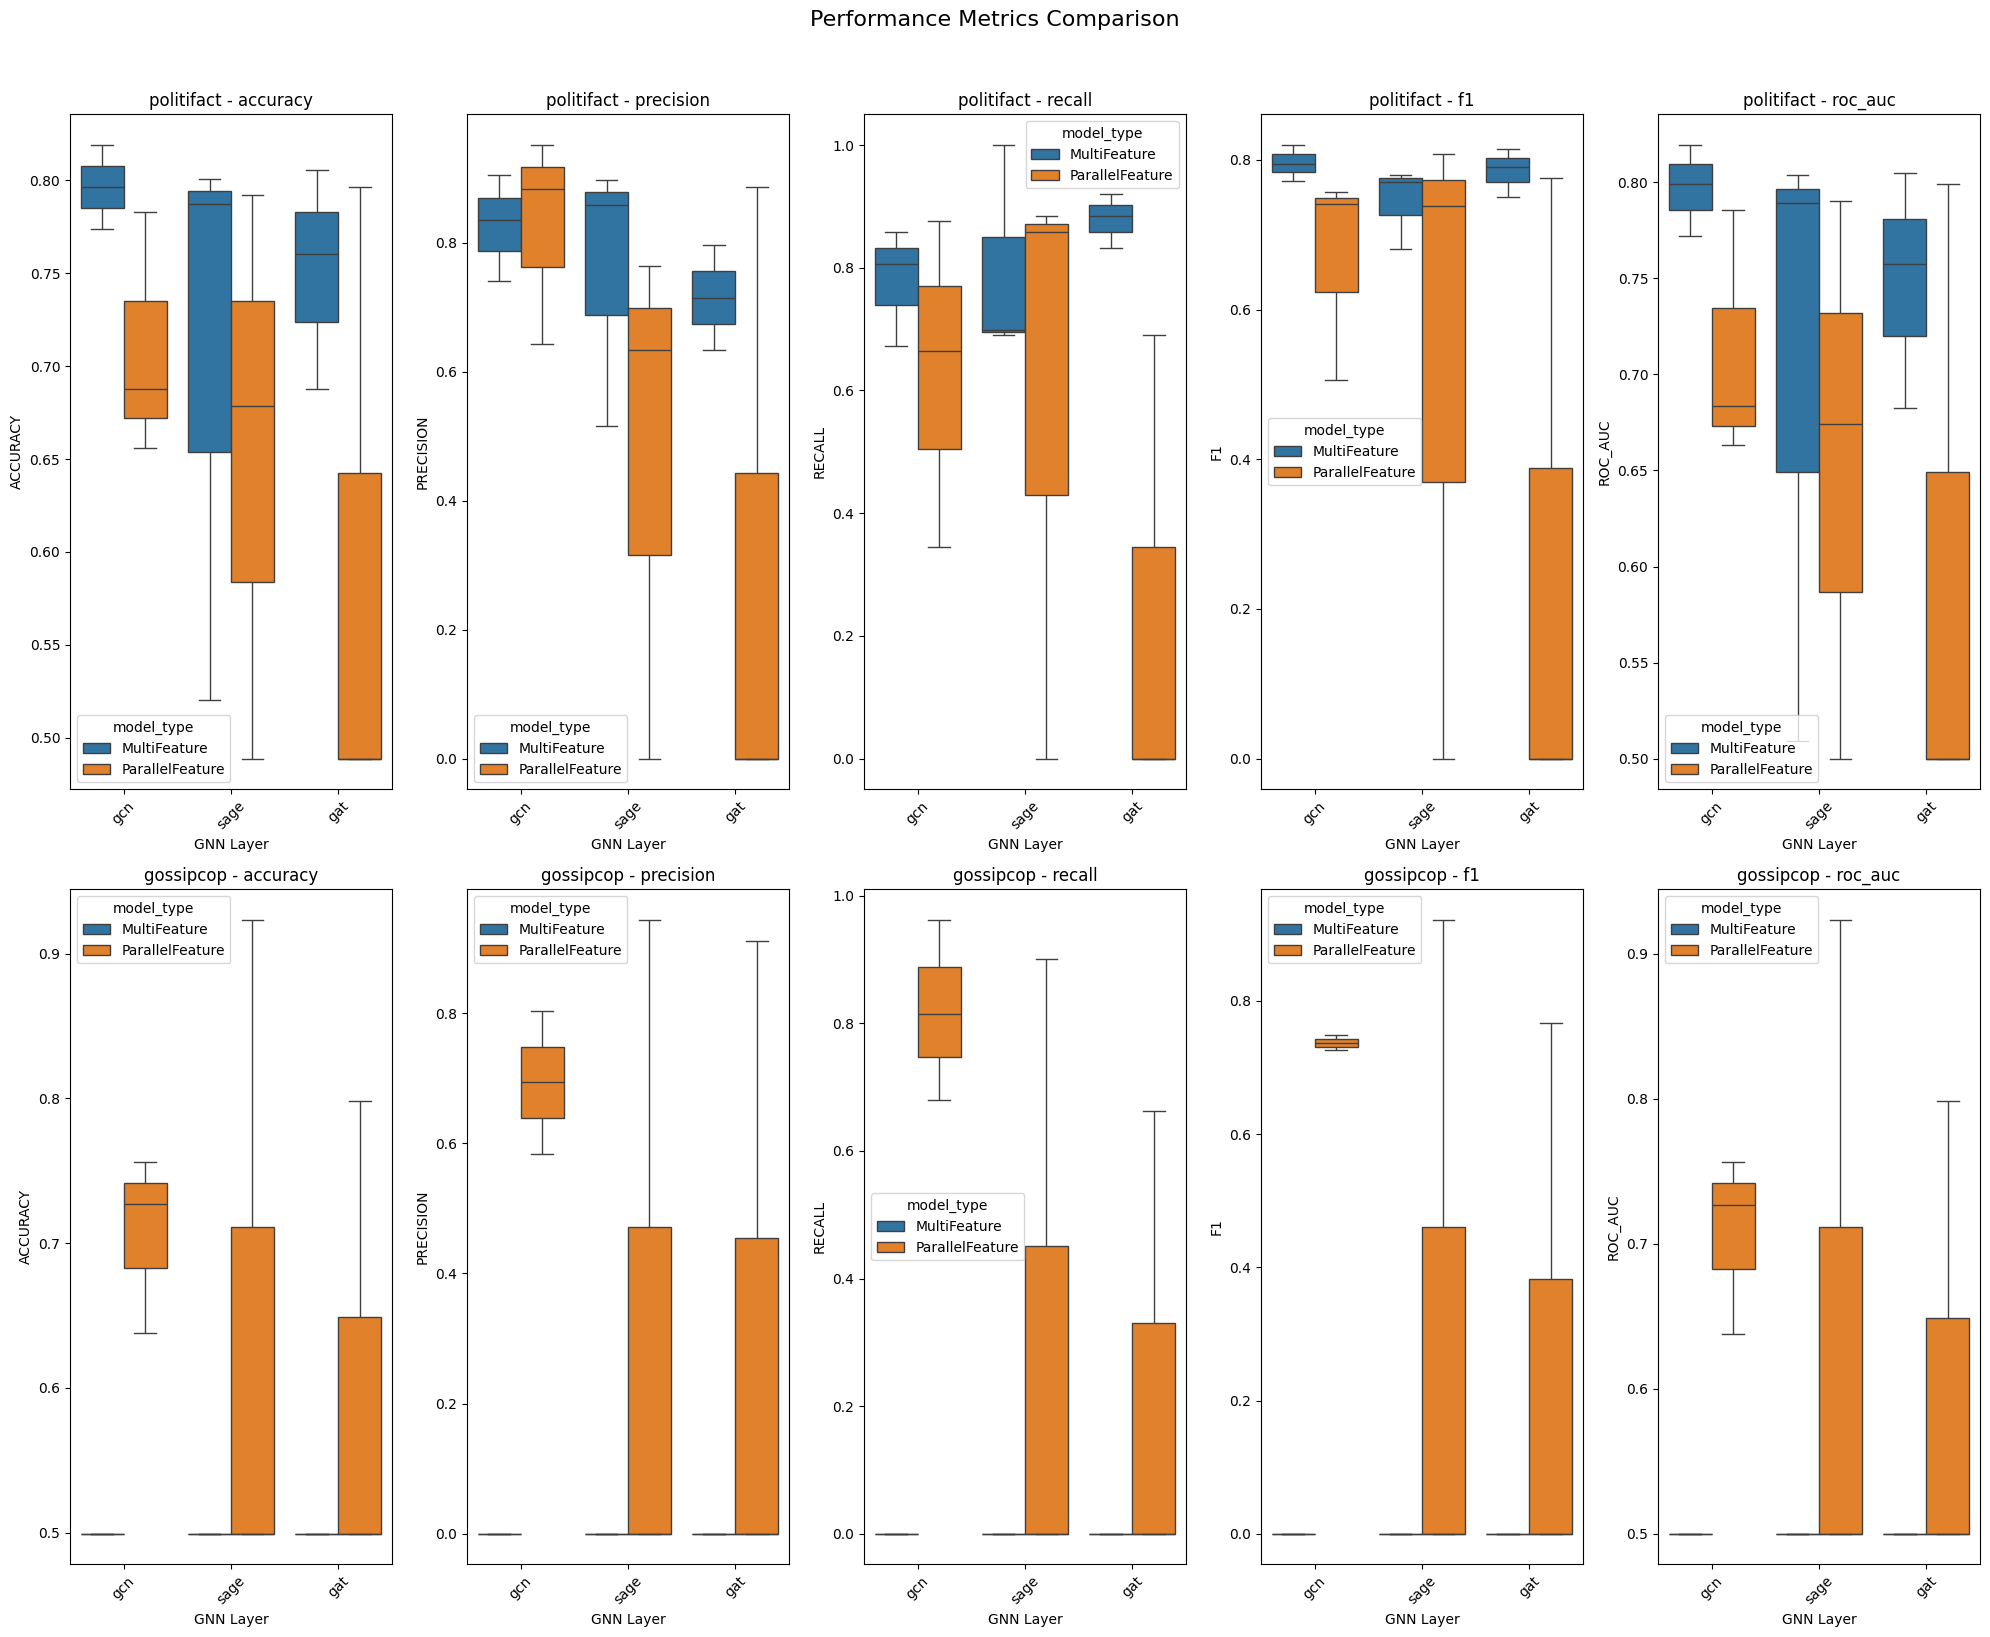

<Figure size 1500x1000 with 0 Axes>

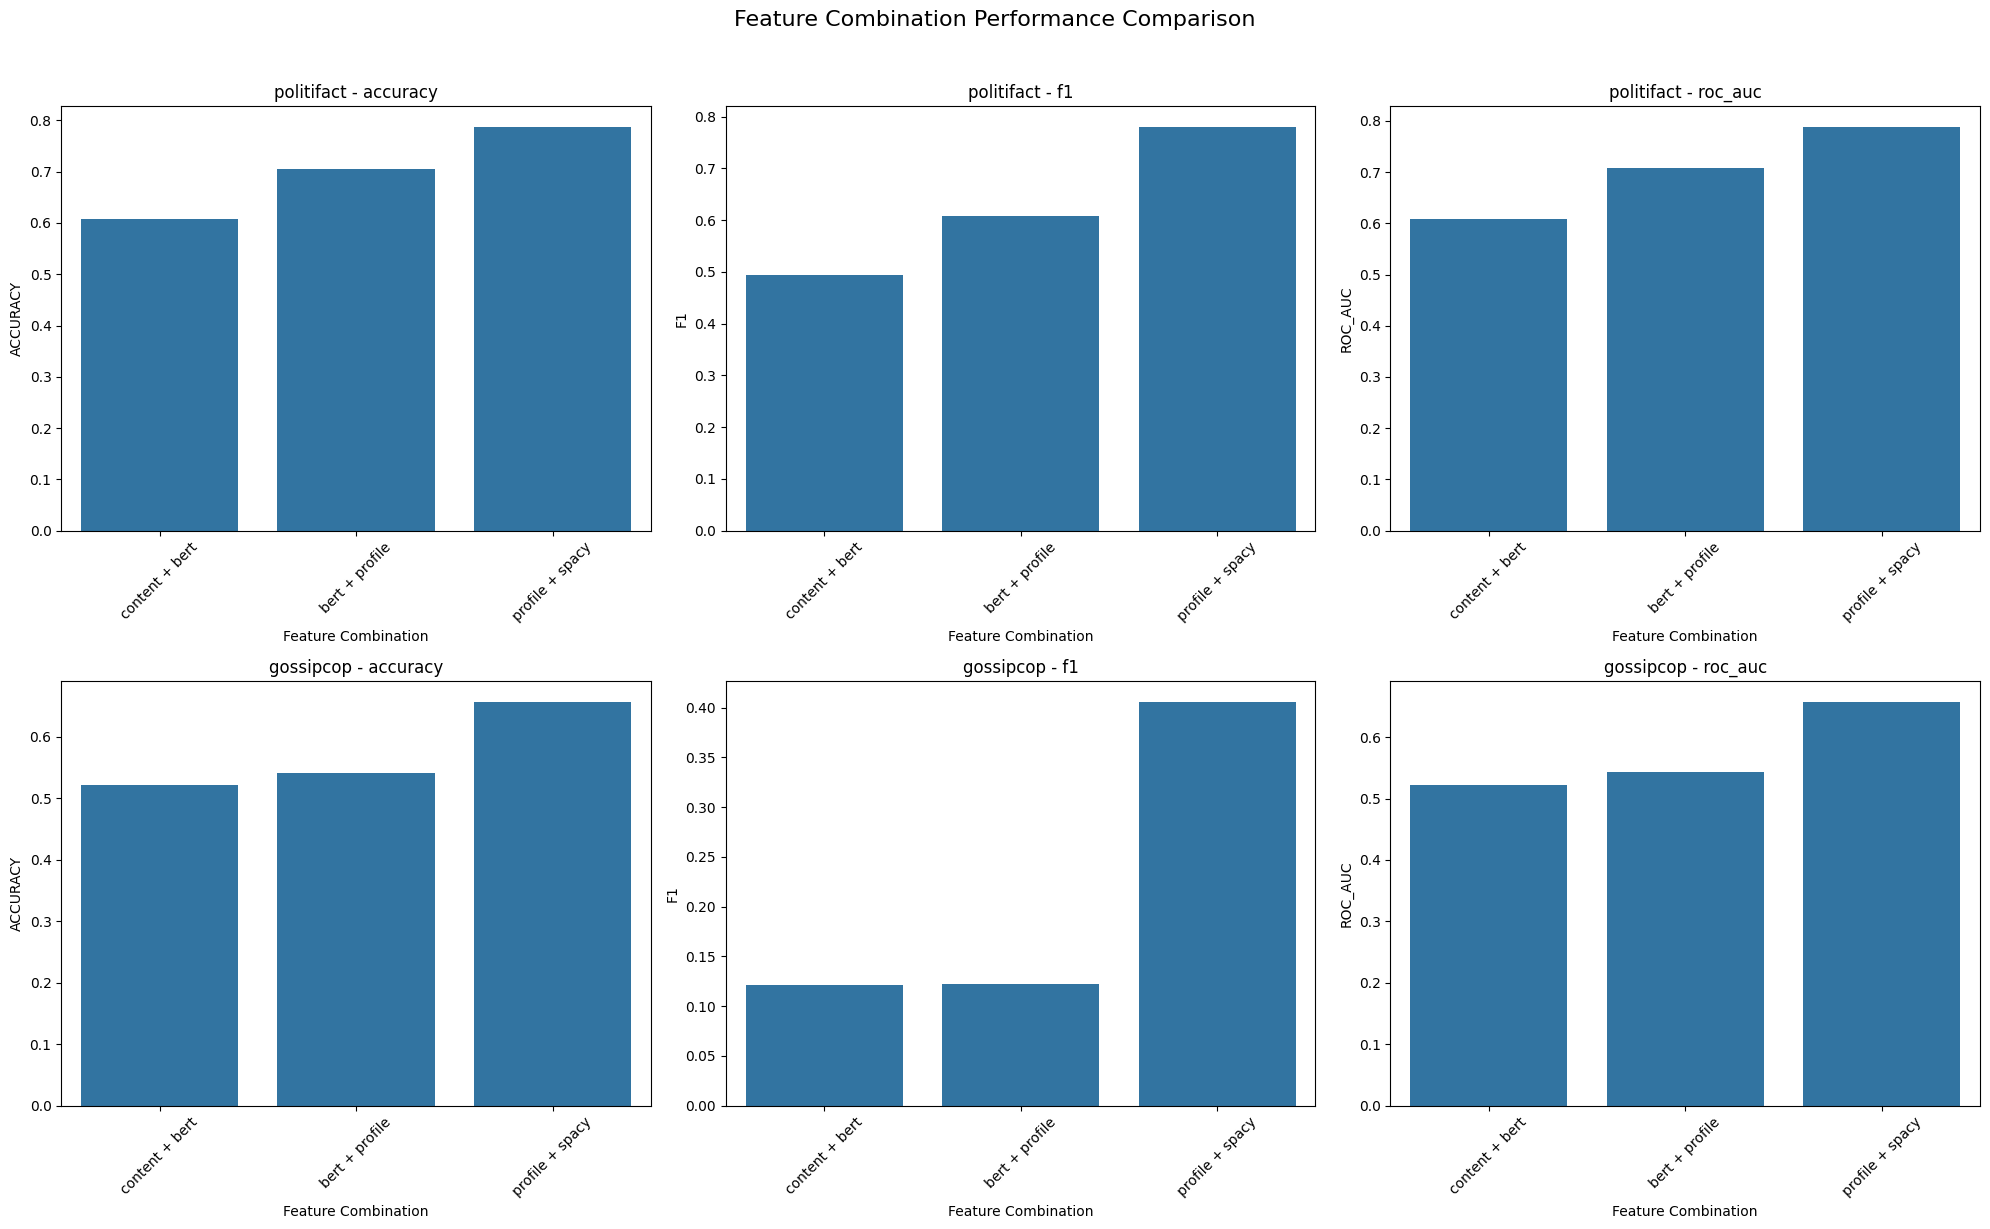

<Figure size 1500x1000 with 0 Axes>

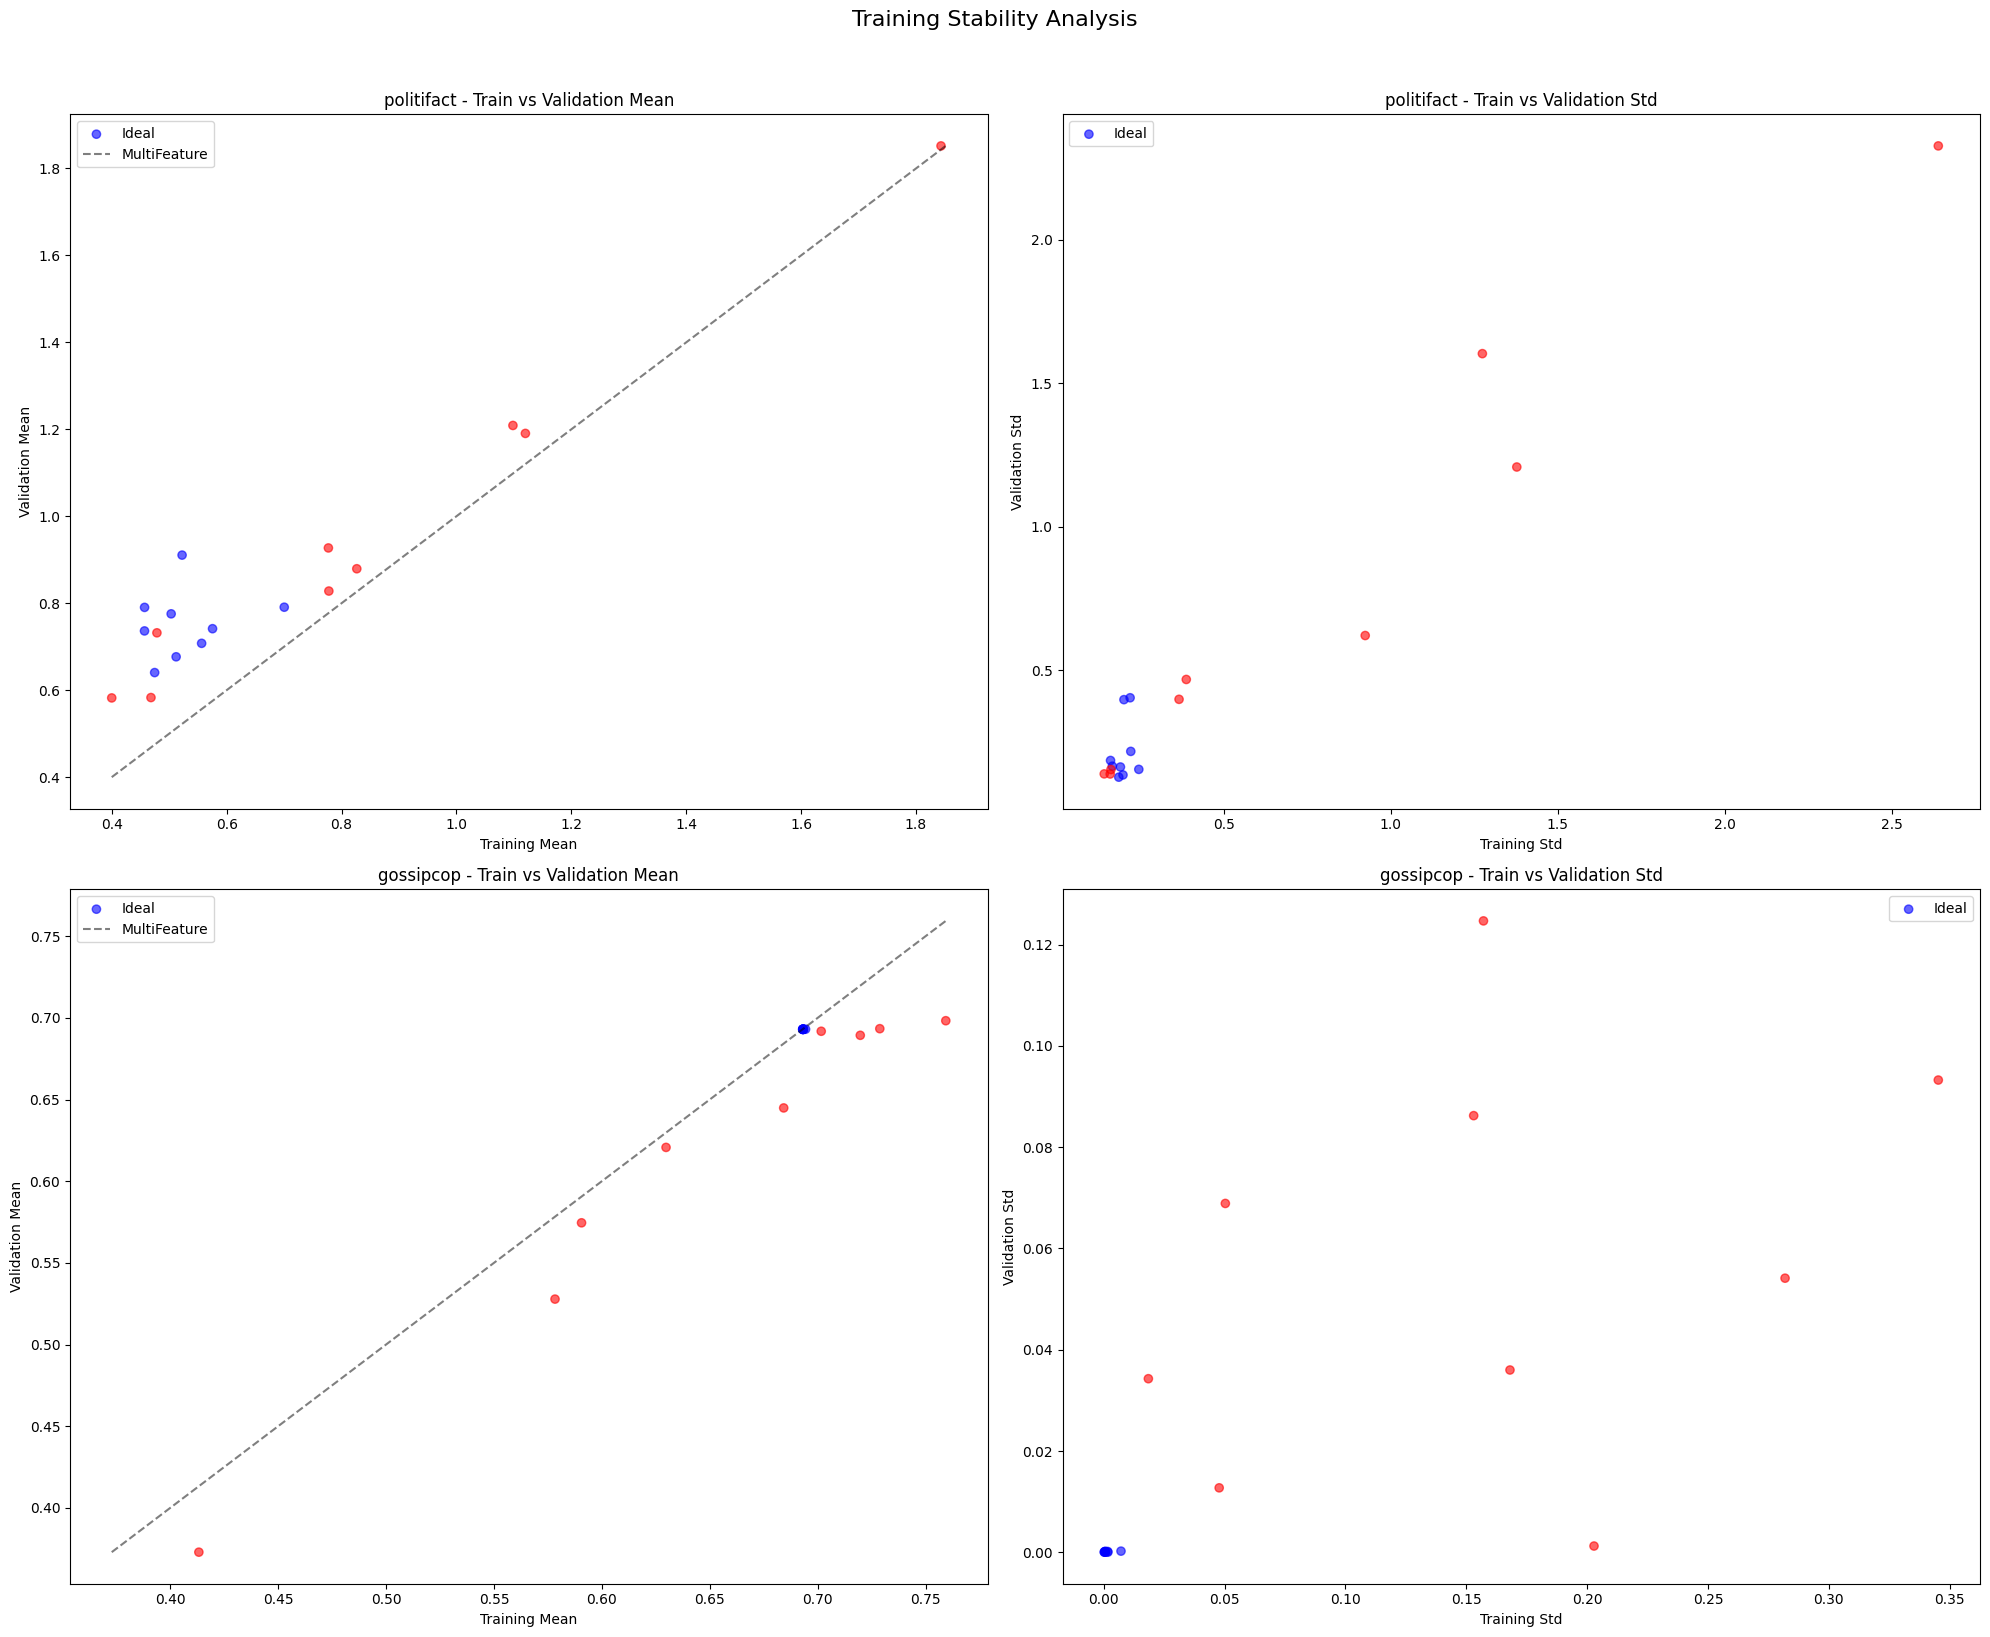

In [74]:
df, stats = run_analysis('./results/multifeature.csv', './results/parallelfeature.csv')

In [77]:
stats

,Dataset,Model,Mean Accuracy,Best Accuracy,Mean F1,Best F1,Mean ROC-AUC,Best ROC-AUC,Best Feature Combo,Best GNN Layer
0,politifact,MultiFeature,0.750126,0.819005,0.774800,0.819820,0.748552,0.819322,"[bert, profile]",gcn
1,politifact,ParallelFeature,0.651081,0.796380,0.480900,0.808333,0.655045,0.798836,"[profile, spacy]",gat
2,gossipcop,MultiFeature,0.499216,0.499216,0.000000,0.000000,0.500000,0.500000,"[content, bert]",gcn
3,gossipcop,ParallelFeature,0.648806,0.923157,0.433365,0.921516,0.649124,0.923192,"[profile, spacy]",sage
